In [22]:
import pandas as pd

# Read the data
df_full = pd.read_csv('./data/train.csv', index_col='Id')
df_test_full = pd.read_csv('./data/test.csv', index_col='Id')

# Remove rows with missing target, separate target from predictors
df_full.dropna(axis=0, subset=['SalePrice'], inplace=True)

#won't use these later
drop_features = ['Utilities', 'Condition1', 'Condition2']
df_full.drop(columns=drop_features, inplace=True)


# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_features = [cname for cname in df_full.columns if
                    df_full[cname].nunique() < 10 and 
                    df_full[cname].dtype == "object"]

# Select numerical columns
numerical_features = [cname for cname in df_full.columns if 
                df_full[cname].dtype in ['int64', 'float64']]


# Keep selected columns only
my_cols = categorical_features + numerical_features
df_full = df_full[my_cols].copy()

#now remove 'SalePrice' from numerical columns so we don't try to apply transformations to it later
#'numerical_features' is used for transformations throughout this script
numerical_features.remove('SalePrice')

ordinal_features = ['Street', 'OverallQual', 'OverallCond', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', \
                    'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', \
                    'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'Fence']

onehot_features = ['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'BldgType', 'HouseStyle', 'RoofStyle', \
                   'RoofMatl', 'MasVnrType', 'Foundation', 'Heating', 'GarageType', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition']

In [23]:
df_full[categorical_features].head()

,MSZoning,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,BldgType,HouseStyle,RoofStyle,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,RL,Pave,NaN,Reg,Lvl,Inside,Gtl,1Fam,2Story,Gable,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,Reg,Lvl,FR2,Gtl,1Fam,1Story,Gable,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,Inside,Gtl,1Fam,2Story,Gable,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
4,RL,Pave,NaN,IR1,Lvl,Corner,Gtl,1Fam,2Story,Gable,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
5,RL,Pave,NaN,IR1,Lvl,FR2,Gtl,1Fam,2Story,Gable,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [63]:
df_full[numerical_features].head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,548,0,61,0,0,0,0,0,2,2008
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,460,298,0,0,0,0,0,0,5,2007
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,608,0,42,0,0,0,0,0,9,2008
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,642,0,35,272,0,0,0,0,2,2006
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,836,192,84,0,0,0,0,0,12,2008


# Fill null values

In [25]:
df_full.isnull().sum().sort_values(ascending=False).head(20)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageFinish      81
GarageQual        81
GarageCond        81
GarageYrBlt       81
GarageType        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtQual          37
BsmtCond          37
MasVnrArea         8
MasVnrType         8
Electrical         1
BsmtFullBath       0
dtype: int64

In [26]:
from sklearn.model_selection import train_test_split

def dataFrameTestValidXY(df):
    df_copy = df.copy()
    y = df_copy['SalePrice']
    X = df_copy.drop(columns=['SalePrice'])

    # Break off validation set from training data
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
    
    return X_train, X_valid, y_train, y_valid

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler


In [28]:
def encodeOrdinalFeatures(x):

    return_value = []
    for x_2 in x:
        
        X = x_2.copy()

        #process the ordinal features into integer ranking
        X["Street"] = X["Street"].map({'Grvl':1, 'Pave':2})

        # print(f'OverallQual: \n{X["OverallQual"].value_counts()}')
        X["OverallQual"] = X["OverallQual"].apply(lambda x: 1 if x<=4 else (2 if x <=7 else 3))

        # print(f'OverallCond: \n{X["OverallCond"].value_counts()}')
        X["OverallCond"] = X["OverallCond"].apply(lambda x: 1 if x<=4 else (2 if x <=7 else 3))

        # print(f'ExterQual: \n{X["ExterQual"].value_counts()}')
        X["ExterQual"] = X["ExterQual"].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4})

        # print(f'ExterCond: \n{X["ExterCond"].value_counts()}')
        X["ExterCond"] = X["ExterCond"].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4})

        # print(f'BsmtQual: \n{X["BsmtQual"].value_counts()}')
        X["BsmtQual"] = X["BsmtQual"].map({'NA':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5})

        # print(f'BsmtCond: \n{X["BsmtCond"].value_counts()}')
        X["BsmtCond"] = X["BsmtCond"].map({'NA':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5})

        # print(f'BsmtExposure: \n{X["BsmtExposure"].value_counts()}')
        X["BsmtExposure"] = X["BsmtExposure"].map({'NA':1, 'No':2, 'Mn':3, 'Av':4, 'Gd':5})

        # print(f'BsmtFinType1: \n{X["BsmtFinType1"].value_counts()}')
        X["BsmtFinType1"] = X["BsmtFinType1"].map({'NA':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})

        # print(f'BsmtFinType2: \n{X["BsmtFinType2"].value_counts()}')
        X["BsmtFinType2"] = X["BsmtFinType2"].map({'NA':1, 'Unf':2, 'LwQ':3, 'Rec':4, 'BLQ':5, 'ALQ':6, 'GLQ':7})

        # print(f'HeatingQC: \n{X["HeatingQC"].value_counts()}')
        X["HeatingQC"] = X["HeatingQC"].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

        # print(f'CentralAir: \n{X["CentralAir"].value_counts()}')
        X["CentralAir"] = X["CentralAir"].map({'N':1, 'Y':2})

        # print(f'Electrical: \n{X["Electrical"].value_counts()}')
        X["Electrical"] = X["Electrical"].map({'FuseP':1, 'FuseF':2, 'FuseA':3, 'SBrkr':4})

        # print(f'KitchenQual: \n{X["KitchenQual"].value_counts()}')
        X["KitchenQual"] = X["KitchenQual"].map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

        # print(f'Functional: \n{X["Functional"].value_counts()}')
        X["Functional"] = X["Functional"].map({'Sal':1, 'Sev':2, 'Maj2':3, 'Maj1':4, 'Mod':5, 'Min2':6, 'Min1':7, 'Typ':8})

        # print(f'FireplaceQu: \n{X["FireplaceQu"].value_counts()}')
        X["FireplaceQu"] = X["FireplaceQu"].map({'NA':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})

        # print(f'GarageFinish: \n{X["GarageFinish"].value_counts()}')
        X["GarageFinish"] = X["GarageFinish"].map({'NA':1, 'Unf':2, 'RFn':3, 'Fin':4})

        # print(f'GarageQual: \n{X["GarageQual"].value_counts()}')
        X["GarageQual"] = X["GarageQual"].map({'NA':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})

        # print(f'GarageCond: \n{X["GarageCond"].value_counts()}')
        X["GarageCond"] = X["GarageCond"].map({'NA':1, 'Po':2, 'Fa':3, 'TA':4, 'Gd':5, 'Ex':6})

        # print(f'PavedDrive: \n{X["PavedDrive"].value_counts()}')
        X["PavedDrive"] = X["PavedDrive"].map({'N':1, 'P':2, 'Y':3})

        # print(f'Fence: \n{X["Fence"].value_counts()}')
        X["Fence"] = X["Fence"].map({'NA':1, 'MnWw':2, 'GdWo':3, 'MnPrv':4, 'GdPrv':5})

        return_value.append(X)
        
    return return_value
print("processOrdinalFeatures") 

processOrdinalFeatures


In [29]:
from sklearn.compose import ColumnTransformer

def normalizeData(Xt, Xv):
    
    global onehot_features
    
    #ordinal encode
    Xt, Xv = encodeOrdinalFeatures([Xt, Xv])
    
    ##IMPUTE missing data
    numerical_imputer = SimpleImputer(strategy='mean')
    numerical_imputer.fit(Xt[numerical_features])
    Xt[numerical_features] = numerical_imputer.transform(Xt[numerical_features])    
    Xv[numerical_features] = numerical_imputer.transform(Xv[numerical_features])    
    
    ordinal_imputer = SimpleImputer(strategy='most_frequent')
    ordinal_imputer.fit(Xt[ordinal_features])
    Xt[ordinal_features] = ordinal_imputer.transform(Xt[ordinal_features])
    Xv[ordinal_features] = ordinal_imputer.transform(Xv[ordinal_features])
    
    onehot_imputer = SimpleImputer(strategy='most_frequent')
    onehot_imputer.fit(Xt[onehot_features])
    Xt[onehot_features] = onehot_imputer.transform(Xt[onehot_features])
    Xv[onehot_features] = onehot_imputer.transform(Xv[onehot_features])
    
    #ENCODE onehot
    onehot_encoder = OneHotEncoder(handle_unknown='ignore')
    onehot_encoder.fit(Xt[onehot_features])
    Xt2 = onehot_encoder.transform(Xt[onehot_features])
    Xv2 = onehot_encoder.transform(Xv[onehot_features])
    
    #convert our onehot list/array to a dataframe
    new_onehot_features = onehot_encoder.get_feature_names_out(onehot_features)
    Xt2 = pd.DataFrame(Xt2.todense(), columns=new_onehot_features)
    Xv2 = pd.DataFrame(Xv2.todense(), columns=new_onehot_features)

    #reset the index
    Xt2.index = Xt.index
    Xv2.index = Xv.index
    
    #merge with the full dataset
    Xt2 = pd.concat([Xt, Xt2], axis=1)
    Xv2 = pd.concat([Xv, Xv2], axis=1)

    #drop the original onehot (nonencoded) columns/features
    Xt2.drop(columns=onehot_features, inplace=True)
    Xv2.drop(columns=onehot_features, inplace=True)
    onehot_features = new_onehot_features

    #SCALE data
    min_max_scaler = MinMaxScaler().fit(Xt2)
    Xt2 = pd.DataFrame(min_max_scaler.transform(Xt2), columns=Xt2.columns)
    Xv2 = pd.DataFrame(min_max_scaler.transform(Xv2), columns=Xv2.columns)
    
    return Xt2, Xv2


In [30]:
X_train, X_valid, y_train, y_valid = dataFrameTestValidXY(df_full.copy())
X_train_2, X_valid_2 = normalizeData(X_train, X_valid)

#type(X_train_2.shape)


In [31]:
X_train_2[ordinal_features].head()

,Street,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence
0,1.0,1.0,0.5,0.5,0.666667,0.5,0.666667,0.666667,1.0,0.0,...,1.0,1.0,0.666667,1.0,0.75,0.0,0.5,0.5,1.0,0.666667
1,1.0,0.5,0.5,0.5,0.666667,0.5,0.666667,0.000000,0.0,0.0,...,0.0,1.0,0.333333,1.0,0.75,0.0,0.5,0.5,1.0,0.666667
2,1.0,0.5,0.5,0.5,1.000000,1.0,0.666667,0.000000,0.8,0.0,...,1.0,1.0,0.333333,1.0,0.75,0.0,0.5,0.5,1.0,0.666667
3,1.0,1.0,0.5,1.0,0.666667,1.0,0.666667,0.000000,1.0,0.0,...,1.0,1.0,0.666667,1.0,0.75,0.5,0.5,0.5,1.0,0.666667
4,1.0,0.5,0.5,1.0,0.666667,1.0,0.666667,0.000000,0.0,0.0,...,1.0,1.0,0.666667,1.0,0.50,0.5,0.5,0.5,1.0,0.666667


In [32]:
X_valid_2[ordinal_features].head()

,Street,OverallQual,OverallCond,ExterQual,ExterCond,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,...,CentralAir,Electrical,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence
0,1.0,0.5,0.0,1.0,0.666667,0.5,0.666667,0.0,0.4,0.0,...,1.0,1.000000,0.333333,0.2,0.50,0.5,0.5,0.5,1.0,0.666667
1,1.0,0.5,0.5,0.5,0.666667,0.5,0.666667,0.0,0.6,0.4,...,1.0,0.666667,0.000000,1.0,0.50,0.0,0.5,0.5,1.0,0.666667
2,1.0,0.5,0.0,0.5,0.666667,0.5,0.666667,0.0,0.2,0.0,...,1.0,1.000000,0.666667,1.0,0.50,0.0,0.5,0.5,1.0,0.666667
3,1.0,0.5,0.5,0.5,0.666667,1.0,0.666667,0.0,0.6,0.0,...,1.0,1.000000,0.333333,1.0,0.50,1.0,0.5,0.5,1.0,0.666667
4,1.0,0.5,0.5,0.5,0.666667,0.5,0.666667,0.0,0.0,0.0,...,1.0,1.000000,0.333333,1.0,0.75,0.0,0.5,0.5,1.0,0.666667


In [33]:
X_train_2[onehot_features].head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
X_valid_2[onehot_features].head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Alley_Grvl,Alley_Pave,LotShape_IR1,LotShape_IR2,LotShape_IR3,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [35]:
X_train_2[numerical_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.000000,0.236301,0.048583,1.0,0.5,0.978261,0.950000,0.282500,0.021239,0.0,...,0.556835,0.000000,0.197441,0.00000,0.0,0.541667,0.0,0.0,0.545455,0.25
1,0.000000,0.133562,0.024773,0.5,0.5,0.652174,0.200000,0.000000,0.000000,0.0,...,0.221583,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.636364,0.75
2,0.058824,0.202055,0.056370,0.5,0.5,0.355072,0.933333,0.000000,0.315487,0.0,...,0.310791,0.000000,0.000000,0.07971,0.0,0.000000,0.0,0.0,0.636364,0.75
3,0.000000,0.166486,0.055926,1.0,0.5,0.942029,0.866667,0.092500,0.538938,0.0,...,0.616547,0.203804,0.107861,0.00000,0.0,0.000000,0.0,0.0,0.545455,0.50
4,0.000000,0.332192,0.057978,0.5,0.5,0.934783,0.866667,0.093750,0.000000,0.0,...,0.606475,0.635870,0.148080,0.00000,0.0,0.000000,0.0,0.0,0.000000,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1163,0.235294,0.208904,0.038000,1.0,0.5,0.920290,0.816667,0.420625,0.514602,0.0,...,0.615827,0.000000,0.234004,0.00000,0.0,0.375000,0.0,0.0,0.545455,0.75
1164,0.000000,0.133562,0.038795,0.0,0.5,0.565217,0.750000,0.000000,0.195575,0.0,...,0.313669,0.394022,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.090909,1.00
1165,0.411765,0.160959,0.035663,0.5,0.5,0.768116,0.466667,0.000000,0.000000,0.0,...,0.387770,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.0,0.272727,1.00
1166,0.588235,0.166486,0.008862,0.5,0.5,0.949275,0.900000,0.011250,0.000000,0.0,...,0.302158,0.194293,0.036563,0.00000,0.0,0.000000,0.0,0.0,0.818182,0.00


In [36]:
X_valid_2[numerical_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.000000,0.166486,0.146617,0.5,0.0,0.615942,0.416667,0.064676,0.539381,0.000000,...,0.348201,0.000000,0.000000,0.362319,0.0,0.000000,0.0,0.0,0.181818,0.25
1,0.176471,0.198630,0.038281,0.5,0.5,0.500000,0.000000,0.000000,0.178319,0.147321,...,0.172662,0.000000,0.000000,0.057971,0.0,0.000000,0.0,0.0,0.636364,0.00
2,0.176471,0.166486,0.026712,0.5,0.0,0.565217,0.000000,0.100625,0.081858,0.000000,...,0.253237,0.000000,0.000000,0.449275,0.0,0.000000,0.0,0.0,0.545455,0.75
3,0.235294,0.212329,0.040688,0.5,0.5,0.760870,0.450000,0.186875,0.173451,0.000000,...,0.363309,0.391304,0.213894,0.000000,0.0,0.000000,0.0,0.0,0.181818,0.50
4,0.823529,0.000000,0.001776,0.5,0.5,0.717391,0.350000,0.238125,0.000000,0.000000,...,0.189928,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.181818,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287,0.588235,0.037671,0.044619,1.0,0.5,0.876812,0.716667,0.000000,0.716372,0.000000,...,0.340288,0.165761,0.054845,0.000000,0.0,0.000000,0.0,0.0,0.363636,0.50
288,0.000000,0.287671,0.066050,1.0,0.5,0.985507,0.966667,0.125000,0.781858,0.481250,...,0.483453,0.000000,0.131627,0.000000,0.0,0.354167,0.0,0.0,0.272727,0.75
289,0.176471,0.133562,0.033747,0.5,0.5,0.318841,0.000000,0.000000,0.074336,0.487500,...,0.155396,0.119565,0.027422,0.000000,0.0,0.000000,0.0,0.0,0.636364,0.25
290,0.058824,0.099315,0.018837,0.0,0.5,0.492754,0.000000,0.000000,0.123894,0.000000,...,0.000000,0.222826,0.000000,0.000000,0.0,0.000000,0.0,0.0,1.000000,0.75


In [37]:
X_train_2.isnull().sum().sort_values(ascending=False).head()

Street               0
Foundation_PConc     0
RoofStyle_Hip        0
RoofStyle_Mansard    0
RoofStyle_Shed       0
dtype: int64

In [38]:
X_valid_2.isnull().sum().sort_values(ascending=False).head()

Street               0
Foundation_PConc     0
RoofStyle_Hip        0
RoofStyle_Mansard    0
RoofStyle_Shed       0
dtype: int64

In [39]:
print(f'X_train_2: {X_train_2.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_valid_2: {X_valid_2.shape}')
print(f'y_valid: {y_valid.shape}')

X_train_2: (1168, 147)
y_train: (1168,)
X_valid_2: (292, 147)
y_valid: (292,)


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate

simplified_model = LinearRegression()
simplified_model.fit(X_train_2, y_train)
cv_results = cross_validate(simplified_model, X_train_2, y_train, cv=5, scoring=('r2', 'neg_mean_squared_error'))
print(cv_results)

simplified_model_score2 = cv_results['test_r2'].mean()
simplified_model_score2

{'fit_time': array([0.04900193, 0.05728388, 0.07400918, 0.04940796, 0.04441309]), 'score_time': array([0.00310397, 0.00184417, 0.00181293, 0.00173116, 0.00156999]), 'test_r2': array([-3.76144570e+18, -1.20671914e+23, -1.26281324e+18, -5.86283775e+20,
       -5.55988822e+16]), 'test_neg_mean_squared_error': array([-2.23887342e+28, -7.79360948e+32, -8.53957271e+27, -4.17244088e+30,
       -2.41922467e+26])}


-2.4252655603338684e+22

In [59]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator = LinearRegression(),
                                                              X = X_train_2, 
                                                              y = y_train, 
                                                              cv = 10)
train_sizes, train_scores, test_scores

(array([ 105,  341,  578,  814, 1051]),
 array([[0.99539114, 0.99412656, 0.99412656, 0.99412656, 0.99412656,
         0.99412656, 0.99412656, 0.99412656, 0.99412656, 0.99412656],
        [0.8568697 , 0.85129   , 0.90500926, 0.93826576, 0.93826576,
         0.93826576, 0.93826576, 0.93826576, 0.93826576, 0.93826576],
        [0.87627249, 0.87210295, 0.92420984, 0.88670876, 0.86729709,
         0.87770198, 0.87770198, 0.87770198, 0.87770198, 0.87770198],
        [0.88028209, 0.88094933, 0.91595294, 0.88779043, 0.8749805 ,
         0.8832092 , 0.88014792, 0.88327962, 0.88327962, 0.88327962],
        [0.88084234, 0.88230299, 0.91280368, 0.88809279, 0.87775029,
         0.8841543 , 0.88214959, 0.88432391, 0.88215832, 0.88409589]]),
 array([[-3.71656828e+00, -6.25105827e-01, -3.98588205e-01,
          1.27285588e-01, -7.15541468e-01, -4.17642525e+00,
          1.95036096e-02, -4.46632551e-01, -5.06490307e-01,
         -1.66315577e+00],
        [-3.46120249e+18, -9.22763152e+22, -1.52511233e+

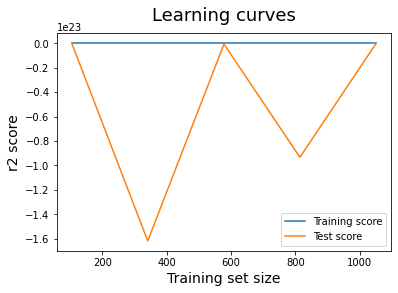

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot the learning curves!
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();

In [14]:
#KEEP THIS

#How to OneHot encode, relabel columns the merge with the rest of data frame finally drop the unencoded onehot columns

# OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X_train[low_cardinality_cols]))
# OH_cols_valid = pd.DataFrame(OH_encoder.transform(X_valid[low_cardinality_cols]))

# # One-hot encoding removed index; put it back
# OH_cols_train.index = X_train.index
# OH_cols_valid.index = X_valid.index

# # Remove categorical columns (will replace with one-hot encoding)
# num_X_train = X_train.drop(object_cols, axis=1)
# num_X_valid = X_valid.drop(object_cols, axis=1)

# # Add one-hot encoded columns to numerical features
# OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
# OH_X_valid = pd.concat([num_X_valid, OH_cols_valid], axis=1)    
